In [44]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.io_utils import load_multiple_res, dist_kwargs_to_str
from utils.pd_utils import compute_outlier_scores, filter_dgms
from utils.fig_utils import full_dist_to_print, dist_to_color
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [45]:
style_file = "utils.style"
plt.style.use(style_file)
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

In [95]:
# hyperparameters
sigmas = np.linspace(0.0, 0.35, 29)
sigmas = np.array([np.format_float_positional(sigma, precision=4, unique=True, trim='0') for sigma in sigmas]).astype(float)
seeds = [0, 1, 2]
n = 1000

dataset = "toy_circle"

In [96]:
distances = {"euclidean": [{}],
             "dtm": [
                 {"k": 4, "p_dtm": 2, "p_radius": 1},
                    ],
                 "eff_res": [
                     {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
                 ],
             "diffusion": [
                 {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
                ]
             }

dist_2_full_dist = {dist: dist + dist_kwargs_to_str(distances[dist][0]) for dist in distances}

# low to high dims

In [ ]:
embd_dims = [2, 10, 20, 30, 40, 50]

In [97]:
# load all PH results
all_res = load_multiple_res(datasets=dataset, 
                            distances=distances,
                            root_path=root_path,
                            n=n,
                            seeds=seeds,
                            sigmas=sigmas,
                            embd_dims=embd_dims, 
                            n_threads=10)

Done with toy_circle 2 euclidean n_outliers=0, perturbation=None
Done with toy_circle 2 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 2 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with toy_circle 2 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 10 euclidean n_outliers=0, perturbation=None
Done with toy_circle 10 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 10 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with toy_circle 10 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 20 euclidean n_outliers=0, perturbation=None
Done with toy_circle 20 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 20 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=

In [98]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dim=1, dob=dob, binary=True)

In [99]:
# compute detection scores
outlier_scores = compute_outlier_scores(all_res, n_features=1, dim=1)

In [100]:
def highlight_cell(x,y, width, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), width,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

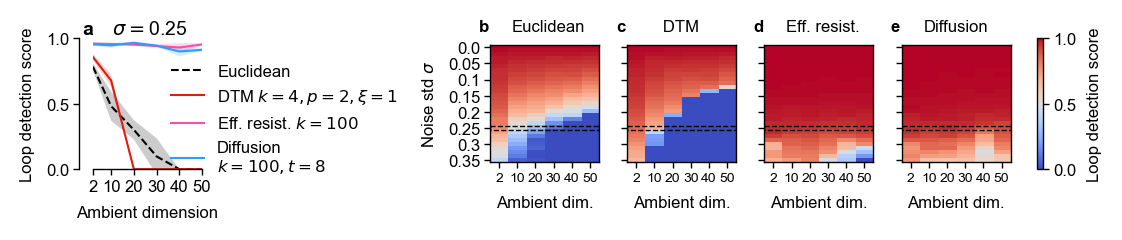

In [101]:
# plot figure
letters = "abcde"

sigma = 0.25

titles = ["Euclidean", "   DTM", "Eff. resist.", "Diffusion"]

fig, ax = plt.subplots(ncols=len(titles)+1, figsize=(5.5, 1.1))

for i, dist in enumerate(distances):
    i+=1
    cax = ax[i]
    
    # plot heat maps for each distance
    ssigs, ddims = np.meshgrid(sigmas, embd_dims)
    
    means = np.stack([outlier_scores[embd_dim][dist].mean(2)[0] for embd_dim in embd_dims])
    stds = np.stack([outlier_scores[embd_dim][dist].std(2)[0] for embd_dim in embd_dims])
    im = ax[i].imshow(means.T, cmap="coolwarm", aspect=1/4.5, vmin=0, vmax=1.0, interpolation="none")
    
    
    highlight_cell(x=0, y=np.where(sigmas == sigma)[0][0], width=len(embd_dims), ax=ax[i], color="black", linewidth=0.5, linestyle="dashed")
    
    
    ax[i].set_xticks(np.arange(len(embd_dims)))
    ax[i].set_xticklabels(embd_dims, fontsize=5)
    
    #for tick in ax[i].xaxis.get_major_ticks()[1::2]:
    #    tick.set_pad(3)
    
    ax[i].set_yticks(np.arange(len(sigmas))[::4])
    
    if i==1:
        ax[i].set_yticklabels([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
        ax[i].set_ylabel("Noise std $\sigma$")

    else:
        ax[i].set_yticklabels([])
    
    ax[i].spines[["top", "right"]].set_visible(True)
    
    ax[i].set_xlabel("Ambient dim.")
   
    ax[i].text(
        s=titles[i-1],
        x=0.2,
        y=1.12,
        transform=ax[i].transAxes,
    )
    ax[i].text(
        s=letters[i],
        x=-0.1,
        y=1.12,
        transform=ax[i].transAxes,
        fontweight="bold",
    )
    
    # add the detection score for the selected sigma to the first panel
    idx = np.where(sigmas == sigma)[0][0]
    
    if dist == "euclidean":
        ax[0].plot(embd_dims, 
                 means[:, idx],
                 color=dist_to_color[dist],
                 label=full_dist_to_print[dist_2_full_dist[dist]],
                 linestyle="dashed"
                 )
    elif dist == "eff_res":
        ax[0].plot(embd_dims, 
                 means[:, idx],
                 color=dist_to_color[dist],
                 label=f"Eff. resist. $k={distances['eff_res'][0]['k']}$"  
                 )
    else:
        ax[0].plot(embd_dims, 
             means[:, idx],
             color=dist_to_color[dist],
             label=full_dist_to_print[dist_2_full_dist[dist]],
             )
    ax[0].fill_between(embd_dims, 
             means[:, idx] - stds[:, idx],
             means[:, idx] + stds[:, idx],
             color=dist_to_color[dist],
             alpha=0.2,
             edgecolor=None
             )
    ax[0].legend(loc='upper center',
                     bbox_to_anchor=(0.5, -0.35),
                     frameon=False
              )

# prettify the first panel
ax[0].set_ylim(0, 1)
ax[0].set_xlim(2, 50)
ax[0].set_xticks(embd_dims)
ax[0].set_xticklabels(embd_dims)
ax[0].set_xlabel("Ambient dimension")
ax[0].set_ylabel("Loop detection score")
ax[0].set_title(" $\sigma = $0.25 ", va="top")
ax[0].set_title(
    letters[0],
    loc="left",
    ha="right",
    va="top",
    fontweight="bold",
)
ax[0].legend(loc=(0.65, -0.1), frameon=False)
ax[0].spines['left'].set_position(('outward', 5))


fig.colorbar(im, ax=ax[1:5], label="Loop detection score")

fig.savefig(os.path.join(fig_path, "fig_dims_dob.pdf"))

# extra high dimensions

In [56]:
embd_dims  =  [50, 100, 200, 500, 1000, 2000, 5000]

In [67]:
# load all PH results
all_res = load_multiple_res(datasets=dataset, 
                            distances=distances,
                            root_path=root_path,
                            n=n,
                            seeds=seeds,
                            sigmas=sigmas,
                            embd_dims=embd_dims, 
                            n_threads=10)

Done with toy_circle 50 euclidean n_outliers=0, perturbation=None
Done with toy_circle 50 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 50 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with toy_circle 50 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 100 euclidean n_outliers=0, perturbation=None
Done with toy_circle 100 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 100 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, perturbation=None
Done with toy_circle 100 diffusion_k_100_t_8_kernel_sknn_include_self_False n_outliers=0, perturbation=None
Done with toy_circle 200 euclidean n_outliers=0, perturbation=None
Done with toy_circle 200 dtm_k_4_p_dtm_2_p_radius_1 n_outliers=0, perturbation=None
Done with toy_circle 200 eff_res_corrected_True_weighted_False_k_100_disconnect_True n_outliers=0, pe

In [68]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dim=1, dob=dob, binary=True)

In [72]:
# compute detection scores
outlier_scores = compute_outlier_scores(all_res, n_features=1, dim=1)

In [73]:
def highlight_cell(x,y, width, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), width,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

In [74]:
outlier_scores[50].keys()

dict_keys(['euclidean', 'dtm', 'eff_res', 'diffusion'])

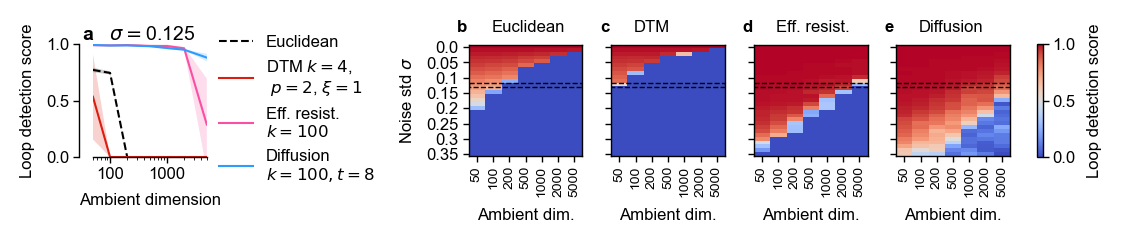

In [93]:
# plot figure
letters = "abcde"

sigma = 0.125

titles = ["Euclidean", "DTM", "Eff. resist.", "Diffusion"]

fig, ax = plt.subplots(ncols=len(titles)+1, figsize=(5.5, 1.1))

for i, dist in enumerate(distances):
    i+=1
    cax = ax[i]
    
    # plot heat maps for each distance
    ssigs, ddims = np.meshgrid(sigmas, embd_dims)
    
    means = np.stack([outlier_scores[embd_dim][dist].mean(2)[0] for embd_dim in embd_dims])
    stds = np.stack([outlier_scores[embd_dim][dist].std(2)[0] for embd_dim in embd_dims])
    im = ax[i].imshow(means.T, cmap="coolwarm", aspect=1/4.25, vmin=0, vmax=1.0, interpolation="none")
    
    
    highlight_cell(x=0, y=np.where(sigmas == sigma)[0][0], width=len(embd_dims), ax=ax[i], color="black", linewidth=0.5, linestyle="dashed")
    
    
    ax[i].set_xticks(np.arange(len(embd_dims)))
    ax[i].set_xticklabels(embd_dims, fontsize=5, rotation=90)
    
    #for tick in ax[i].xaxis.get_major_ticks()[1::2]:
    #    tick.set_pad(3)
    
    ax[i].set_yticks(np.arange(len(sigmas))[::4])
    
    if i==1:
        ax[i].set_yticklabels([0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
        ax[i].set_ylabel("Noise std $\sigma$")

    else:
        ax[i].set_yticklabels([])
    
    ax[i].spines[["top", "right"]].set_visible(True)
    
    ax[i].set_xlabel("Ambient dim.")
   
    ax[i].text(
        s=titles[i-1],
        x=0.2,
        y=1.12,
        transform=ax[i].transAxes,
    )
    ax[i].text(
        s=letters[i],
        x=-0.1,
        y=1.12,
        transform=ax[i].transAxes,
        fontweight="bold",
    )
    
    # add the detection score for the selected sigma to the first panel
    idx = np.where(sigmas == sigma)[0][0]
    
    if dist == "euclidean":
        ax[0].plot(embd_dims, 
                 means[:, idx],
                 color=dist_to_color[dist],
                 label=full_dist_to_print[dist_2_full_dist[dist]],
                 linestyle="dashed"
                 )
    elif dist == "eff_res":
        ax[0].plot(embd_dims, 
                 means[:, idx],
                 color=dist_to_color[dist],
                 label=f"Eff. resist.\n$k={distances['eff_res'][0]['k']}$"  
                 )
    elif dist == "dtm":
        ax[0].plot(embd_dims, 
                 means[:, idx],
                 color=dist_to_color[dist],
                 label=f"DTM $k={distances['dtm'][0]['k']}$,\n $p={distances['dtm'][0]['p_dtm']}$, "+r"$\xi=$"+f"${distances['dtm'][0]['p_radius']}$"  
                 )    
    else:
        ax[0].plot(embd_dims, 
             means[:, idx],
             color=dist_to_color[dist],
             label=full_dist_to_print[dist_2_full_dist[dist]],
             )
    ax[0].fill_between(embd_dims, 
             means[:, idx] - stds[:, idx],
             means[:, idx] + stds[:, idx],
             color=dist_to_color[dist],
             alpha=0.2,
             edgecolor=None
             )
    ax[0].legend(loc='upper center',
                     bbox_to_anchor=(0.5, -0.35),
                     frameon=False
              )

# prettify the first panel
ax[0].set_ylim(0, 1)
ax[0].set_xlim(50, 5000)

ax[0].set_xscale("log")

ax[0].set_xticks([100, 1000])
ax[0].set_xticklabels([100, 1000])
ax[0].set_xlabel("Ambient dimension")
ax[0].set_ylabel("Loop detection score")
ax[0].set_title(" $\sigma = $0.125 ", va="top")
ax[0].set_title(
    letters[0],
    loc="left",
    ha="right",
    va="top",
    fontweight="bold",
)
ax[0].legend(loc=(1.05, -0.3), frameon=False)
ax[0].spines['left'].set_position(('outward', 5))


fig.colorbar(im, ax=ax[1:5], label="Loop detection score")

fig.savefig(os.path.join(fig_path, "fig_high_dims_dob.pdf"), dpi=300)